<a href="https://colab.research.google.com/github/rland93/pendulum/blob/master/notebooks/lqr_gpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!rm -rf pendulum
!git clone https://github.com/rland93/pendulum.git
!pip install ipympl

Cloning into 'pendulum'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 345 (delta 147), reused 273 (delta 89), pack-reused 0
Receiving objects: 100% (345/345), 6.27 MiB | 28.90 MiB/s, done.
Resolving deltas: 100% (147/147), done.


Set system path so that pendulum module can be found.

In [27]:
import sys
sys.path.append('pendulum/')
print(sys.executable)
print(sys.version)

/usr/bin/python3
3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


Import packages

In [9]:
import numpy as np
from pendulum import controller, pendulum, sim, utils
from pendulum.viz import Visualizer
from IPython.display import HTML
import matplotlib.pyplot as plt

We set the timestep of the simulation (`dt`), the total simulation time (`t_final`), and create a pendulum. We set the pendulum to be in the upright position: 

$$ [x, \dot{x}, \theta, \dot{\theta}] = [0,0,0,0]$$

In [10]:
dt = 0.01
t_final = 15
pend = pendulum.Pendulum(2.0, 3.0, 2.0, initial_state=np.array([0,0,-np.pi,0]))

These parameters define our force function. We can define this function however we like; here, it is a sinusoidal impulse function that peaks at 4 seconds.

In [13]:
fig, ax = plt.subplots()
c1, c2, c3, c4 = 2, 3.0, 7, 2
fshift = 6
force_fn = lambda t: c1 * np.sin(c2*t) * c3/(c4*np.sqrt(np.pi)) * np.exp(-((t-fshift)/c4)**2)
fx = np.linspace(0,t_final, 500)
fy = force_fn(fx)
ax.plot(fx, fy)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Define the simulation with our parameters

In [15]:
simulation = sim.Simulation(dt, t_final, force_fn)

We create a new LQR controller. $Q$ has the weighted cost function over the inputs; here, we penalize error in $\theta$ highest. We also want to penalize control input, becuase it's assumed that we have finite actuation.

In [16]:
Q = [1,0,100,0]
R = 0.001
cont = controller.LQR_GPR(pend, dt, 7, 10, Q, R)

`simulate` actually runs the simulation. It calculates the pendulum state for each dt from t=0 to t=`t_final`.

In [17]:
results = simulation.simulate(pend, cont, plot=False)

100%|██████████| 1501/1501 [03:42<00:00,  6.75it/s]


We can create plots on the `results` dataframe returned by the simulation. For example, here is a plot of the states:

In [18]:
results[('lerr','t')] = results[('lpred','t')].shift(1, fill_value=0.0) - results[('state','t')]
results[('nlerr','t')] = results[('nlpred','t')].shift(1, fill_value=0.0) - results[('state','t')]

In [28]:
fig, ax = plt.subplots()
for s in results['state']:
    ax.plot(results[('state', s)], label=s)
    ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Here is a plot of the control actions over time.

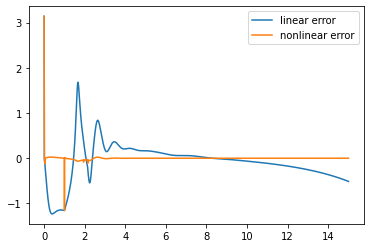

In [24]:
fig, ax = plt.subplots()
ax.plot(results['lerr'], label='linear error')
ax.plot(results['nlerr'], label='nonlinear error')
ax.legend()

We can create an animation of our results using the `Visualizer` class:

In [29]:
visualizer = Visualizer(results, pend, speed=4)
anim = visualizer.animate((9.5, 5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Some systems may have trouble displaying animations in the browser. We can prerender the animation as an HTML5 video which will display at full speed on all platforms (this cell may take a while to execute.) 

In [22]:
HTML(anim.to_html5_video())